In [1]:
import numpy as np
import time
import re
from collections import defaultdict
from methods import *
from ourAlgorithm import *
import math
import random
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import matplotlib.pyplot

In [2]:
# Read the dataset into data (list of lines)
data = [line.strip() for line in open("data")]

In [3]:
newdata, activities, types, all_days, all_sensors, all_activities = [], [], defaultdict(lambda:[]), set(), set(), set()
reg = "(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2}(?:\.\d+)?)\s+([MDT]\d+)\s+(.+)"
enter_or_leave = "(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2}(?:\.\d+)?)\s+(.+HOME)\s+(.+)"
for i,line in enumerate(data):
    line = re.sub("\s+"," ",line.replace("\t"," "))
    # there are four common typos in the dataset
    if re.search("OF Meal_Preparation end",line):
        line = line.replace("OF Meal_Preparation end", "OFF Meal_Preparation end")
    if re.search("O Relax",line):
        line = line.replace("O Relax", "ON Relax")
    if re.search("OcFF",line):
        line = line.replace("OcFF", "OFF") 
    if re.search("OFcF",line):
        line = line.replace("OFcF", "OFF") 
    if "T002 25 Sleeping end" in line:
        print("    3rd type of atypical input:",line)
    m = re.search(reg,line)
    if m:
        date, time, sensor, activity = tuple(m.group(i) for i in range(1,5))
        all_days.add(date)
        all_sensors.add(sensor)
        types[sensor].append((date,time,activity))
        newdata.append((date,time,sensor,activity))
        m_activ = re.search("(ON|OFF|OPEN|CLOSE|25|O|OF) (.+)",activity)
        if m_activ:
            activities.append((date,time,m_activ.group(2)))
            all_activities.add(m_activ.group(2).replace(" begin","").replace(" end",""))
    elif re.search(enter_or_leave,line):
        m = re.search(enter_or_leave,line)
        print("  2nd type of atypical input:  ",line)
    else:
        print("1st type of atypical input:    ",line)
all_days = sorted(list(all_days))
all_sensors = sorted(list(all_sensors))
all_activities = sorted(list(all_activities))
data_by_day = defaultdict(lambda:[])
for date,time,sensor,text in newdata:
    data_by_day[date].append((time,sensor,text))

1st type of atypical input:     2011-05-10 18:42:45.169231 c OFF
  2nd type of atypical input:   2011-05-17 11:40:03.013619 LEAVEHOME 180
  2nd type of atypical input:   2011-05-17 14:58:04.907136 LEAVEHOME 300
  2nd type of atypical input:   2011-05-17 18:31:56.044148 LEAVEHOME 300
  2nd type of atypical input:   2011-05-18 12:22:23.315366 LEAVEHOME 300
  2nd type of atypical input:   2011-05-18 14:12:13.738946 ENTERHOME 6592
    3rd type of atypical input: 2011-06-11 23:58:10.004834 T002 25 Sleeping end


Note that there is one activity ending with a temperature sensor instead of motion sensor. <br>
We decide to ignore, at this point, entries of the 1st and 2nd type.<br>
newdata = list of tuples (date, time, sensor, descriptive text)<br>
activities = list of tuples (date, time, activity begin|and)<br>
types = dictionary with name of sensors as keys and a list of descriptive texts as values<br>
all_days = a sorted list with all the dates included in the dataset<br>
all_sensors = a sorted list with all the sensors included in the dataset<br>
all_activities = a sorted list with all the activities included in the dataset<br>
data_by_day  = a dictionary in which we have all the data from newdata directly accesible by day

<h3>We need to clean data before anything else. For example, if we have a sensor that turns on and never turns off, or a sensor turning off that was already off</h3>

In [4]:
# First, let's clean the data
types,newdata = cleanMotionSensorsData(types,newdata)

A total of 64 entries have been eliminated


<h3>This is where we start to process the sensors. First, get the possible duration intervals for each MOTION sensor</h3>

In [133]:
sensor_durations,sensor_times = getSensorIntervals(types)

In [134]:
listSens=[]
for elem in newdata[:1000]:
    if elem[2][0]=="M" and elem[3][:2]=="ON":
        listSens.append(elem[2])
listSens

['M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M002',
 'M003',
 'M002',
 'M003',
 'M002',
 'M007',
 'M003',
 'M007',
 'M003',
 'M005',
 'M004',
 'M004',
 'M007',
 'M004',
 'M007',
 'M005',
 'M007',
 'M003',
 'M002',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M002',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M003',
 'M007',
 'M003',
 'M007',
 'M003',
 'M007',
 'M007',
 'M005',
 'M007',
 'M005',
 'M004',
 'M007',
 'M004',
 'M005',
 'M006',
 'M008',
 'M020',
 'M020',
 'M020',
 'M020',
 'M020',
 'M020',
 'M010',
 'M020',
 'M011',
 'M020',
 'M020',
 'M020',
 'M012',
 'M013',
 'M020',
 'M014',
 'M013',
 'M020',
 'M009',
 'M020',
 'M009',
 'M009',
 'M009',
 'M009',
 'M009',
 'M009',
 'M009',
 'M009',
 'M020',
 'M010',
 'M013',
 'M020',
 'M014',
 'M018',
 'M019',
 'M015',
 'M019',
 'M019',
 'M019',
 'M015',
 'M019',
 'M015',
 'M015',
 'M019',
 'M015',
 'M015',
 'M019',
 'M019',
 

In [135]:
mtrix = np.zeros((32,32))

In [136]:
for i in range(len(listSens) -1):
    a = int(listSens[i][1:])
    b = int(listSens[i+1][1:])
    mtrix[a,b]+=1

In [137]:
mtrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.])

Show statistics for one particular sensor. Note that getSensorIntervals can be easily modified to get information from doors as well.

In [6]:
t="M001"
v = np.array(sorted(sensor_durations[t]))
print("There are a total of %s entries generated by the %s sensor"%(len(v),t))
print("The mean is %.2f and the standard deviation is %.2f"%(np.mean(v),np.std(v)))
print("Among these, there are exactly %s values three times the std farther away from the mean"%np.sum(v>np.mean(v)+3*np.std(v)))
print("(We will not plot these values in the histogram)")
discard = np.sum(v>np.mean(v)+3*np.std(v))

There are a total of 6088 entries generated by the M001 sensor
The mean is 5.85 and the standard deviation is 72.48
Among these, there are exactly 3 values three times the std farther away from the mean
(We will not plot these values in the histogram)


<h3>Check the distribution that the intervals follow (there is a dedicated Notebook for this part)</h3>

<h3>Read the coordinates of the sensors from file and plot them on the image with the house</h3>

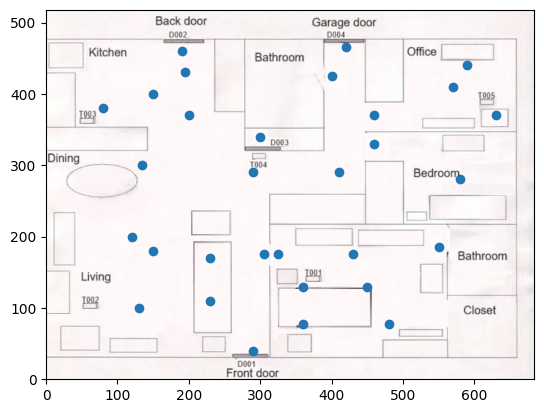

In [138]:
dictionary = {}
for line in open("sensor_coordinates.txt"):
    a = line.strip().split(",")
    dictionary[a[0]]=(int(a[1]),int(a[2]))
x_list,y_list = zip(*dictionary.values())
fig, ax = plt.subplots(clear=True)
im = plt.imread("aruba3.jpg")
im = ax.imshow(im, extent=[0, 684, 0, 518])
ax.scatter(x_list,y_list)
plt.show()

<h3>We want to make a video with the sensors that are ON in a given time interval</h3>

It turns out it is too slow

In [8]:
"""
selected_data = [tupla for tupla in newdata if tupla[2][0]=="M" and tupla[0]=="2010-11-04"]
data1,sen,days = getDataForMatrix(selected_data)
vector = np.zeros((len(sen),))

X, _ = makeMatrix(data1,sen,vector,len(days))
"""
print("Skip")

Skip


In [9]:
"""
prev = np.zeros((len(sen),1))
toplot=[]
i=0
for line in X:
    if not np.array_equal(line,prev):
        active_sensors = [sen[i] for i in np.where(line == 1)[0] ]
        toplot.append(plot_for_offset([dictionary[sensor] for sensor in active_sensors],i))
    i+=1  
    prev = line
    if i==5*3600:
        break
imageio.mimsave('test.gif',toplot, fps=1)
"""
print("Skip")

Skip


<h3>Now we will check the motion sensors that are ON at the same time</h3>

We build X_all, a 3 dimensional array such that X_all[i] is a discretized representation of the sensors that are on on the i-th day

In [10]:
# we want to have all the motion sensors
sen = [s for s in all_sensors if s[0]=="M"]
X_all = np.zeros((len(all_days),24*60*60,len(sen)))
vector = np.zeros((len(sen),))
for i,day in enumerate(all_days):
    selected_data = [tupla for tupla in newdata if tupla[2][0]=="M" and tupla[0]==day]
    data1,_,days = getDataForMatrix(selected_data)
    X,vector = makeMatrix(data1,sen,vector)
    X_all[i] = X

In [34]:
set_of_active_sensors = set()
for d,day in enumerate(all_days):
    for line in X_all[d]:
        if np.sum(line)>1:
            active_sensors = [sen[i] for i in np.where(line == 1)[0]]
            set_of_active_sensors.add(tuple(active_sensors))
len(set_of_active_sensors)

7856

Next we plot the active sensors that are ON at the same time, but only for a few examples (there are 7894 in total) 

In [35]:
#plt.rcParams["figure.figsize"] = [5, 10]
#plt.rcParams["figure.autolayout"] = True
"""
i=0
for elem in set_of_active_sensors:
    plt.clf()
    fig, ax = plt.subplots()
    im = plt.imread("aruba3.jpg")
    im = ax.imshow(im, extent=[0, 684, 0, 518])
    x_list,y_list = zip(*[dictionary[t] for t in elem])
    ax.scatter(x_list,y_list)
    name = ",".join(list(elem))
    print(name)
    plt.savefig("Figures/%s.png"%name)
    i += 1
    if i==3:
        break
"""
i=0

Assuming everything is fine, this is the algorithm that generates one day of sensor data arbitrarily (but based on what we have)

First, we populate, for each second in the day, the possible sensors (or group of sensors) that are ON in that precise second

In [36]:
do_nothing = []
for sec in range(24*60*60):
    target = [np.where(X_all[i][sec]>0)[0] for i in range(len(all_days))]
    counts = defaultdict(lambda:0)
    for x in target:
        counts[tuple(x)] += 1
    do_nothing.append("%.3f"%(counts[()]/220))

In [37]:
min(do_nothing),max(do_nothing)

('0.700', '1.000')